In [1]:
import sys
import os
import random
import csv
from pprint import pprint

from matplotlib import pyplot as plt

module_path = os.path.abspath(os.path.join("..", ".."))
sys.path.append(module_path)

from perceptron import Perceptron, cross_validation
from perceptron.data_utils import transpose, to_binary


In [2]:
with open("sonar.csv", "rt") as f:
    data = [
        [float(value) for value in features] + [target]
        for *features, target in [line for line in csv.reader(f) if line]
    ]

*features, targets = transpose(data)
features = transpose(features)
mapping, targets = to_binary(targets)

print("Labels mapping:")
for label in mapping:
    print(label, mapping[label])


Labels mapping:
M 0
R 1


# Single layer model

Training: 100% |████████████████████████████████████████| 100/100, binary_accuracy=0.889, mse=0.0886


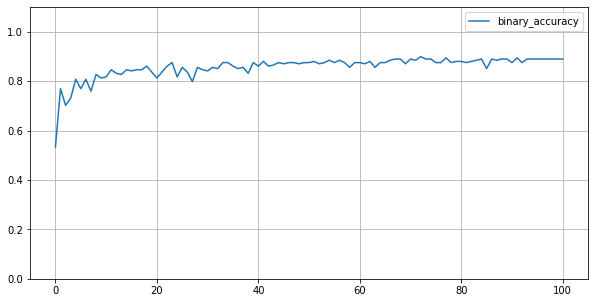

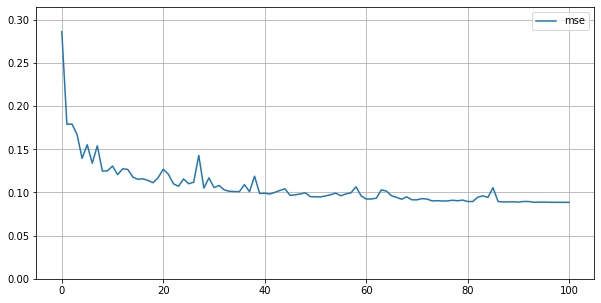

In [3]:
# random.seed(0)

model = Perceptron(
    inputs=60,
    layer_sizes=[1],
    activations="sigmoid",
    init_method="he",
    optimizer="adam",
)

epochs = 100

history = model.train(
    training_inputs=features,
    training_targets=targets,
    epochs=epochs,
    batch_size=4,
    base_learning_rate=0.05,
    learning_rate_decay="linear",
    metrics=["binary_accuracy", "mse"],
)

fig = plt.figure(figsize=(10, 5))
ax = fig.add_subplot()

ax.plot(range(epochs + 1), history["binary_accuracy"], label="binary_accuracy")

ax.set_ylim(bottom=0, top=1.1)
ax.grid()
ax.legend()
plt.show()

fig = plt.figure(figsize=(10, 5))
ax = fig.add_subplot()

ax.plot(range(epochs + 1), history["mse"], label="mse")

ax.set_ylim(bottom=0, top=max(history["mse"]) * 1.1)
ax.grid()
ax.legend()
plt.show()


# Multi-layer model

Training: 100% |████████████████████████████████████████| 100/100, binary_accuracy=0.875, mse=0.104


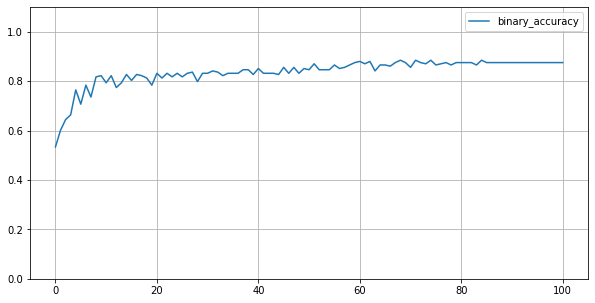

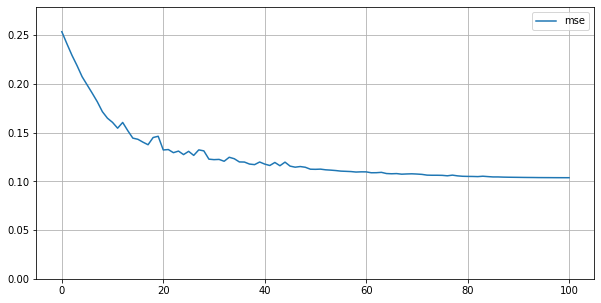

In [4]:
model = Perceptron(
    inputs=60,
    layer_sizes=[4, 1],
    activations="sigmoid",
    init_method="he",
    optimizer="adam",
)

epochs = 100

history = model.train(
    training_inputs=features,
    training_targets=targets,
    epochs=epochs,
    batch_size=8,
    base_learning_rate=0.01,
    learning_rate_decay="linear",
    metrics=["binary_accuracy", "mse"],
)

fig = plt.figure(figsize=(10, 5))
ax = fig.add_subplot()

ax.plot(range(epochs + 1), history["binary_accuracy"], label="binary_accuracy")

ax.set_ylim(bottom=0, top=1.1)
ax.grid()
ax.legend()
plt.show()

fig = plt.figure(figsize=(10, 5))
ax = fig.add_subplot()

ax.plot(range(epochs + 1), history["mse"], label="mse")

ax.set_ylim(bottom=0, top=max(history["mse"]) * 1.1)
ax.grid()
ax.legend()
plt.show()


# Cross validating multi-layer model

In [5]:
random.seed(0)

model_params = dict(
    inputs=60,
    layer_sizes=[4, 1],
    activations="sigmoid",
    init_method="he",
    optimizer="adam",
)

epochs = 100

history = cross_validation(
    inputs=features,
    targets=targets,
    fold_count=3,
    epoch=epochs,
    batch_size=8,
    base_learning_rate=0.01,
    learning_rate_decay="linear",
    model_params=model_params,
    metrics=["binary_accuracy"],
)


Training: 100% |████████████████████████████████████████| 100/100, binary_accuracy=0.862, val_binary_accuracy=0.743
Training: 100% |████████████████████████████████████████| 100/100, binary_accuracy=0.914, val_binary_accuracy=0.812
Training: 100% |████████████████████████████████████████| 100/100, binary_accuracy=0.842, val_binary_accuracy=0.797


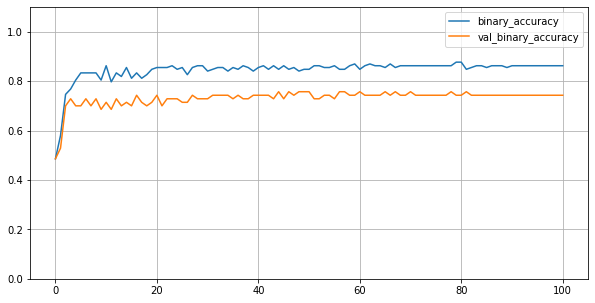

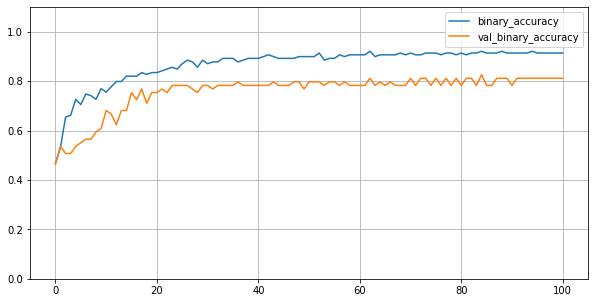

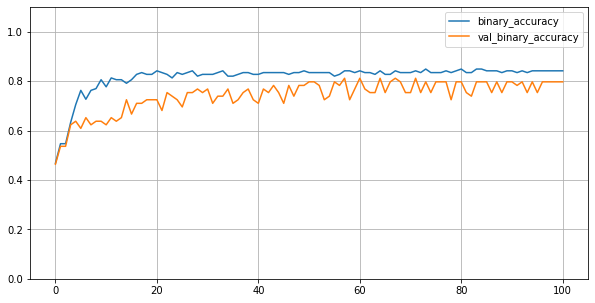

In [6]:
for run in history:
    fig = plt.figure(figsize=(10, 5))
    ax = fig.add_subplot()

    for metric in ["binary_accuracy", "val_binary_accuracy"]:
        ax.plot(range(epochs + 1), run[metric], label=metric)

    ax.set_ylim(bottom=0, top=1.1)
    ax.grid()
    ax.legend()
    plt.show()
